# Homework 8 - Andrea Lazzari

### Neurosience - Excitatory-Inhibitory Two Neurons System

	
Study the stability of the excitatory-inhibitory two neurons system for the parameters:

$$

M = \begin{pmatrix}

M_{EE} & M_{EI} \\
M_{IE} & M_{II}

\end{pmatrix} \quad \quad

h = \begin{pmatrix}
h_E \\
h_I
\end{pmatrix}

$$

$$

M = \begin{pmatrix}

1.25 & -1 \\
1 & 0

\end{pmatrix} \quad \quad

h = \begin{pmatrix}
10 \\
-10
\end{pmatrix}

$$

The time constants are $\tau_E = 10$ ms and different $\tau_I$. 
  
Simulate a trajectory in the stable regime and one in the limit cycle regime.

---

## The Framework

<p align="center">
 <img src = "EI_model.png"
 width="500" height="300" >
</p>


The dynamics of the excitatory-inhibitory two neurons system is described by:

$$
\begin{cases}

\tau_E \cdot \dfrac{dv_E}{dt} = -v_E + \psi(h_E + M_{EE}v_E - M_{EI}v_I ) \\
\\
\tau_I \cdot \dfrac{dv_I}{dt} = -v_I + \psi(h_I + M_{IE}v_E - M_{II}v_I ) \\


\end{cases}
$$

where:
* $v_E$ and $v_I$ are the membrane potentials of the excitatory and inhibitory neurons, respectively
* $\tau_E$ and $\tau_I$ are the time constants of the excitatory and inhibitory neurons
* $h_E$ and $h_I$ are the external inputs to the excitatory and inhibitory neurons
* $M_{EE}$, $M_{EI}$, $M_{IE}$, $M_{II}$ are the synaptic weights between the excitatory and inhibitory neurons, concerning mutual and self interactions

As non-linear function $\psi$ we consider the ReLU function:

$$
\psi(x) = \begin{cases}
x & \text{if } x > 0 \\
0 & \text{otherwise}

\end{cases}
$$

---

### Simulation of the system

In [5]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
import matplotlib

from scipy.integrate import odeint

import pandas as pd 
import plotly.express as px

from dash import Dash, dcc, html
import plotly.graph_objs as go
from dash.dependencies import Input, Output , State
from jupyter_dash import JupyterDash



In [6]:
#excitatory-inhibitory two neurons system simulation

M_EE = 1.25         
M_EI = -1      
M_IE = 1          
M_II = 0

h_E = 10
h_I = -10

tau_E = 10
tau_I = 7   # parameter to change

v_E_0 = 19
v_I_0 = 19

def ReLU(x):
	return x * (x>0)

def system(s, t, M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, tau_I):
    v_E, v_I = s
       
    dv_E_dt = (1/tau_E) * (-v_E + ReLU(h_E + M_EE * v_E + M_EI * v_I ) )               
    dv_I_dt = (1/tau_I) * (-v_I + ReLU(h_I + M_IE * v_E + M_II * v_I ) )              
    
    return [dv_E_dt, dv_I_dt]

t = np.linspace(0, 1000, 1567)   # time_domain

s0 = [v_E_0, v_I_0]   # initial conditions


To plot the dynamics we make an interactive plot:

* The user can choose the time constant $\tau_I$ of the inhibitory neuron
* Then with Submit button the user can plot the dynamics of the system

In [7]:
pd.options.plotting.backend = "plotly"

app = JupyterDash(__name__)

app.layout = html.Div([
        dcc.Slider(min=0, max=50, step=1, value=tau_I, id ='slider', tooltip={"placement": "bottom", "always_visible": True}),
        html.Button(id='submit-button', type='submit', children='Submit', style={'padding':10,'fontSize':18}),
        html.Div(id='slider-output')], 
                      )

@app.callback(Output('slider-output', 'children'),
             [Input('submit-button', 'n_clicks')],
             [State('slider', 'value')])
                                     
                                     
                                     
def update_output(clicks, slider):
        if clicks is not None:
        
            tau_I = slider
            
            solution = odeint(system, s0, t, args=(M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, tau_I))
            
            arr = np.array([t, solution[:,0], solution[:,1]]).T
            df = pd.DataFrame(arr, columns = ['t[s]', 'V_Exc', 'V_Inh'])

            fig = px.line(df , x='t[s]', title='Excitatory-Inhibitory Two Neurons System - tau_I = ' + str(tau_I) + ' ms',
                          y=['V_Exc', 'V_Inh'], 
              labels={'value':'Dynamics', 'variable':'Neuron', 't[s]':'t [s]'},
              markers=True, height=600, width=1100)

            
            fig.update_layout(font=dict(size=20))
            
            return dcc.Graph(figure=fig)
            

app.run_server(mode='inline')

Changing the parameter $\tau_I$ from this interactive plot we can see:

* When $\tau_I \lesssim 3 $ seems to be a particular solution that is stable: it requires a more in depth analysis.

* When $\tau_I < 40$ ms: the system converges to a stable solution, the real part of the eigenvalues will be **negative**, and the fixed point will be **stable**.


* When $\tau_I \geq 40$ ms: the system oscillates, the real part of the eigenvalues will be **positive**, and the fixed point will be **unstable**.

Let's analyze all these regimes

---

### Stability Analysis

As a first step we find the equilibrium point $(v_E^*, v_I^*)$ of the system:

$$
\begin{cases}
\dfrac{dv_E}{dt} = 0 \\
\\
\dfrac{dv_I}{dt} = 0
\end{cases}

\quad \to \quad 

\begin{pmatrix}

\big( 1 - M_{EE} \big) & -M_{I} \\
-M_{IE} & \big(1- M_{II}\big)

\end{pmatrix} 
\begin{pmatrix}
v_E^* \\
v_I^*
\end{pmatrix}

=
\begin{pmatrix}
h_E \\
h_I
\end{pmatrix}


$$


$$

\text{fixed point} \quad (v_E^*, v_I^*) = \dfrac{1}{ \big( 1 - M_{EE} \big)\big(1- M_{II}\big) M_{EI} M_{IE}} \begin{pmatrix}

\big( 1 - M_{II} \big) & M_{EI} \\
M_{IE} & \big(1- M_{EE}\big)

\end{pmatrix} 
\begin{pmatrix}
h_E \\
h_I
\end{pmatrix}


$$

Substituting the numerical values for the parameters, we obtain:

$$
\begin{pmatrix}
v_E^* \\
v_I^*
\end{pmatrix}

=
\begin{pmatrix}
26.67 \\
16.67
\end{pmatrix}


$$

We can show that this is the unique fixed point of the system considering also the cases where the argument of $\psi$ (ReLU) is negative.
In the equation for $\tau_I$ we have that the argument of $\psi$ is negative if $ v_E < 10$ and in this case we have:

$$
v_I^* = 0 \quad \to \quad -v_E^* + \psi(10 + 1.25v_E^* - \cancel{M_{EI}v_I^*} ) = 0 \quad \to \quad 0.25 v_E^* = -10
$$

That is "non-physical".

If the ReLU is negative in the relation of $v_E^*$ we have:

$$
v_E^* = 0 \quad \to \quad -v_I^* + \psi(-10 + \cancel{M_{EE}v_E^*} ) = 0 \quad \to \quad v_I^* = 0
$$

But this would lead to the fact that the argument of $\psi$ in the first differential equation is $10$, that contraddicts our assumption of e negative argument of the ReLU.


---

From the previous considerations, we consider the argument of the non-linear function $\psi$ positive in both equations.  



The Jacobian matrix of the system in the fixed point is:

$$

J \rvert_{v^*} = \begin{pmatrix}
-\dfrac{(1 - M_{EE})}{\tau_E} & \dfrac{M_{EI}}{\tau_E} \\
\\
\dfrac{M_{IE}}{\tau_I} & -\dfrac{(1 - M_{II})}{\tau_I}

\end{pmatrix}


$$

Diagonalizing, the eigenvalues of the Jacobian matrix are:

$$
\lambda_{\pm} = \bigg [ \dfrac{\big(M_{EE} - 1\big)}{\tau_E} + \dfrac{\big(M_{II} - 1\big)}{\tau_I} \pm 
\sqrt{ \bigg( \dfrac{\big(1- M_{EE}\big)}{\tau_E} + \dfrac{\big(1- M_{II}\big)}{\tau_I} \bigg)^2 + \dfrac{4 M_{EI} \cdot M_{IE}}{\tau_E \cdot \tau_I} - \dfrac{4 \big(1- M_{EE}\big) \big(1- M_{II}\big)}{\tau_E \cdot \tau_I}  }  \bigg]
$$

To verify the nature of the fixed point, we study the sign of the square root term substituting the numerical values of the parameters of the case we are analyzing:

$$
\bigg(-0.025 + \dfrac{1}{\tau_I} \bigg)^2 - \dfrac{0.4}{\tau_I} + \dfrac{0.4 \cdot 0.25}{\tau_I} > 0
$$

$$
\bigg(-0.025 + \dfrac{1}{\tau_I} \bigg) > \sqrt{ \dfrac{0.3}{\tau_I}}
$$

Making the substitution $\eta = \sqrt{\tau_I}$ and solving we obtaing:

$$
\eta_{\pm} = \dfrac{- \sqrt{0.3} \pm \sqrt{0.4}}{0.05} \quad \to \quad 

\begin{cases}
\eta_+ \approx 1.69

\\

\eta_- \approx -25.2

\end{cases}
$$

Considering only the physical solution (being $\tau_I$ a time constant, exclude the negative $\eta_-$) we have that the eighenvalues of the Jacobian evaluated in the fixed point are complex conjugate if $\boxed{ \tau_I \gtrsim 2.87}$ and real otherwise.

---

### Conmplex Conjugate Regimes

When the two eighenvalues form a complex conjugate pair the behaviour around the fixed point is oscillatory, and the trajectory either spirals into the fixed point if the real part of the eigenvalues is negative, or out from the fixed point, if the real part is positive. 
In the first case ($Re(\lambda) < 0$) the fixed point is stable, while in the second case ($Re(\lambda) > 0$) it is unstable.

However, because of the non-linear term involved into equations, the unstable trajectory does not expand indefinitely, but it converges toward a so-called **limit cycle**. The onset of these different behaviours, either stationary or sustained oscillations, is ultimately controlled by the parameter
$\tau_I$ that we are free to control.   

The point that separates these two regimes is known as a **bifurcation point**.


When $\tau_I > 2.87$ we can have:

* $Re(\lambda) = 0$: the fixed point is a center and the solution will be periodic

This last case happens if:

$$
\dfrac{\big(M_{EE} - 1\big)}{\tau_E} - \dfrac{\big(M_{II} - 1\big)}{\tau_I} = 0 

\quad \to \quad \dfrac{1}{\tau_I} = \dfrac{1}{4 \cdot 10} \quad \to \quad \boxed{\tau_I = 40} 
$$





---

In [8]:
fixed_point = [26.67 , 16.67]

tau_i = [18, 40, 63]
solutions = []
for tau in tau_i:
    solution = odeint(system, s0, t, args=(M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, tau))
    solutions.append(solution)
    
X, Y = np.meshgrid(np.linspace(0, 80, 20), np.linspace(0, 80, 20))
U, V = system([X, Y], '', M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, tau_i[0])

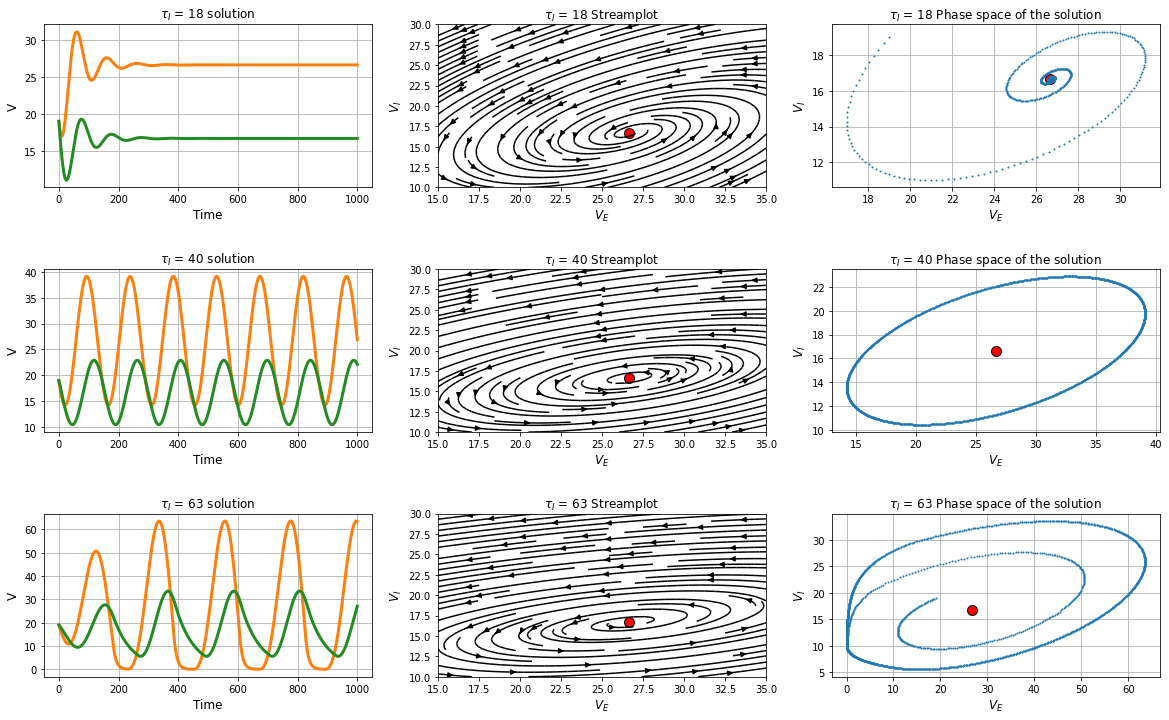

In [9]:
fig, ax_ = plt.subplots(3, 3, figsize = (20, 12))
ax = ax_.flatten()
for i in range(3):
    X, Y = np.meshgrid(np.linspace(15, 35, 200), np.linspace(10, 30, 200))
    U, V = system([X, Y], '', M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, tau_i[i])

    ax[3 * i].plot(t, solutions[i][:, 0], color = 'C1', zorder = 2, linewidth = 3)
    ax[3 * i].plot(t, solutions[i][:, 1], color = 'forestgreen', zorder = 2, linewidth = 3)
    ax[3 * i].set_xlabel('Time', fontsize = 12)
    ax[3 * i].set_ylabel('V', fontsize = 12)
    ax[3 * i].grid(zorder = 1)
    ax[3 * i].set_title(f'$\\tau_I$ = {tau_i[i]} solution')
    
    
    ax[3 * i + 1].set_title(f'$\\tau_I$ = {tau_i[i]} Streamplot')
    ax[3 * i + 1].scatter(fixed_point[0], fixed_point[1], color = 'red', 
                          label = 'Fixed point', zorder = 2, s= 100, edgecolor = 'black')
    ax[3 * i + 2].scatter(fixed_point[0], fixed_point[1], color = 'red', 
                          label = 'Fixed point', zorder = 2,s= 100, edgecolor = 'black')  
  
    ax[3 * i + 1].streamplot(X, Y, U, V, density = 1, color = 'black')
    ax[3 * i + 1].set_xlabel('$V_E$', fontsize = 12)
    ax[3 * i + 1].set_ylabel('$V_I$', fontsize = 12)
    
    
    ax[3 * i + 2].scatter(solutions[i][:, 0], solutions[i][:, 1], color = 'C0', 
                          label = 'Initial conditions', s=1,  zorder = 2)
    ax[3 * i + 2].set_title(f'$\\tau_I$ = {tau_i[i]} Phase space of the solution')
    ax[3 * i + 2].grid(zorder = 1)
    ax[3 * i + 2].set_xlabel('$V_E$', fontsize = 12)
    ax[3 * i + 2].set_ylabel('$V_I$', fontsize = 12)

fig.subplots_adjust(hspace=0.5)

---

## $\tau_I \lesssim 2.87$ - Real eighenvalues Regime

In this case we have to analyze the sign of the real eighenvalues to understand the nature of the fixed point. Also here we subtitute the numerical values for the parameters.

$$

0.025 - \dfrac{1}{\tau_I} \pm \sqrt{\bigg(-0.025 + \dfrac{1}{\tau_I} \bigg)^2 - \dfrac{0.4}{\tau_I} + \dfrac{0.1}{\tau_I}} > 0
$$

With some algebraic manipulations we arrive to the condition:

$$
0 > -0.4 \cdot \dfrac{1}{\tau_I} + 0.1 \cdot \dfrac{1}{\tau_I}

\quad \to \quad 

-0.3 \cdot \dfrac{1}{\tau_I} > 0

$$

That is never verifyed, so the eighenvalues are always negative, and the fixed point is stable.

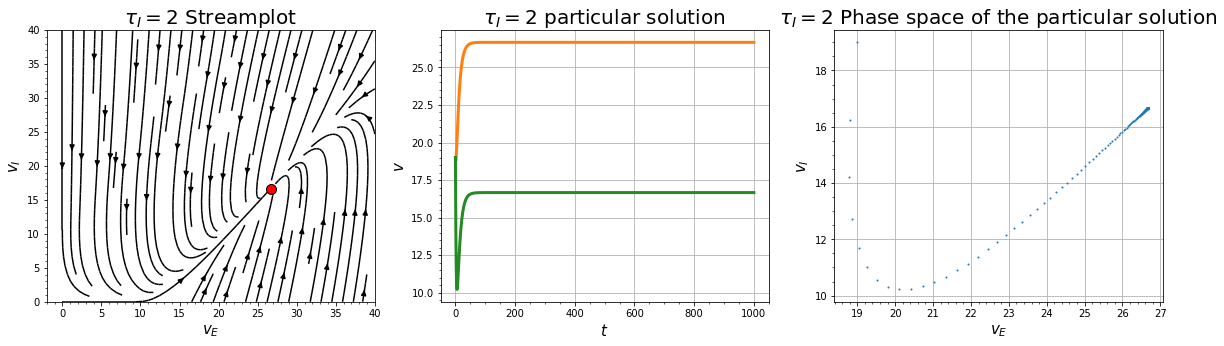

In [10]:
X, Y = np.meshgrid(np.linspace(0, 40, 200), np.linspace(0, 40, 200))
U, V = system([X, Y], '', M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, 2)
solution = odeint(system, s0, t, args=(M_EE, M_EI, M_IE, M_II, h_E, h_I, tau_E, 2))

fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax1, ax2, ax3 = ax.flatten()
ax1.streamplot(X, Y, U, V, density = 1, color = 'black')
ax1.scatter(fixed_point[0], fixed_point[1], color = 'red', label = 'Fixed point',
            zorder = 2, s= 100, edgecolor = 'black')

ax1.set_title('$\\tau_I = 2$ Streamplot', fontsize = 20)
ax1.set_xlabel('$v_E$', fontsize = 15)
ax1.set_ylabel('$v_I$', fontsize = 15)

ax2.plot(t, solution[:, 0], zorder = 2, color = 'C1', linewidth = 3, label = '$v_E$')
ax2.plot(t, solution[:, 1], zorder = 2, color = 'forestgreen', linewidth = 3, label = '$v_I$')

ax2.set_title('$\\tau_I = 2$ particular solution', fontsize = 20)

ax2.grid(zorder = 1)
ax2.set_xlabel('$t$', fontsize = 15)
ax2.set_ylabel('$v$', fontsize = 15)
ax3.scatter(solution[:, 0], solution[:, 1], color = 'C0', s=1, zorder = 2)

ax3.set_title('$\\tau_I = 2$ Phase space of the particular solution', fontsize = 20)

ax3.grid(zorder = 1)
ax3.set_xlabel('$v_E$', fontsize = 15)
ax3.set_ylabel('$v_I$', fontsize = 15)

for ax_ in ax.flatten():
    ax_.minorticks_on()
plt.show()

As we expected we do not have a spiralizing solution and the fixed point is stable, compatible with the fact that the eigenvalues are negative.